## BERT with Auxiliary Features

1. Load Data
2. Train Test Split
3. Build Tensors
4. Define Model Architecture
4. Run Train and Test Steps


In [1]:
pip install -U nltk

In [2]:
!pip install scikeras

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import xgboost
import re
import nltk
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import seaborn as sns
import scipy
from math import sqrt
from scipy import stats
from datetime import date
import numpy as np
import random
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.metrics import sensitivity_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/immo_data.csv', encoding="ISO-8859-1")

In [6]:
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(16, 10)})

missing_data = df.isnull().sum()

In [7]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date


In [8]:
numeric_columns=  ['totalRent', 'baseRent', 'livingSpace',   'serviceCharge', 'heatingCosts',
                     'thermalChar', 'noRoomsRange', 'livingSpaceRange','noRooms', 'noParkSpaces', 'floor', 'numberOfFloors',
                    'picturecount','pricetrend', 'baseRentRange', 'telekomUploadSpeed',  'lastRefurbish',  'yearConstructedRange', 'yearConstructed']

df[numeric_columns]= df[numeric_columns].astype(float)

In [9]:
df.drop( columns= ['telekomHybridUploadSpeed', 'electricityBasePrice', 'electricityKwhPrice', 'energyEfficiencyClass', 'petsAllowed', 'houseNumber'], inplace= True)

In [10]:
def round_val(x):
    return round(x)

for i in numeric_columns:
     df[i].fillna(df[i].mean(), inplace=True)

df[numeric_columns]= df[numeric_columns].apply(lambda x: round(x) )
cat_columns= list( set(df.columns) - set(numeric_columns))
df_num= df[['scoutId']+numeric_columns]

In [11]:
today = date.today()
df_num['yearConstructed']= df_num['yearConstructed'].astype(int)
df_num['lastRefurbish']= df_num['lastRefurbish'].astype(int)
df_num['property_age']= int(today.year)- df_num['yearConstructed']
df_num['refurbish_age']= int(today.year)- df_num['lastRefurbish']

df_num.drop( columns= ['yearConstructed', 'lastRefurbish'], inplace= True)
numeric_columns = list( set(df_num.columns)- set(['yearConstructed', 'lastRefurbish']) )

In [12]:
for col in numeric_columns:
    df_num= df_num[df_num[col]>0]

df_num= df_num[df_num['totalRent']>df_num['baseRent']]
df_num= df_num[df_num['baseRent']>100]

In [13]:
df_num= df_num[ (df_num['totalRent'] < df_num['totalRent'].quantile(0.95)) &
                ( df_num['baseRent'] < df_num['baseRent'].quantile(0.95))&
                ( df_num['livingSpace'] < df_num['livingSpace'].quantile(0.95))&
                ( df_num['serviceCharge'] < df_num['serviceCharge'].quantile(0.95))&
                ( df_num['heatingCosts'] < df_num['heatingCosts'].quantile(0.95))&
                ( df_num['thermalChar'] < df_num['thermalChar'].quantile(0.95))&
                ( df_num['noRooms'] < df_num['noRooms'].quantile(0.95))&
                ( df_num['property_age'] < df_num['property_age'].quantile(0.95))&
                ( df_num['refurbish_age'] < df_num['refurbish_age'].quantile(0.95))&
                ( df_num['floor'] < df_num['floor'].quantile(0.95))&
                ( df_num['numberOfFloors'] < df_num['numberOfFloors'].quantile(0.95))
                ]

In [14]:
df_cat= df[cat_columns]
df_mix = pd.merge(df_num, df_cat, on='scoutId')
df_mix= df_mix.dropna()
df_mix.reset_index(drop=True, inplace=True)

In [15]:
def clean_feat(text):

    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'\s+', ' ', text).strip()
    text= re.sub(r'[0-9]+', '',text)

    return text

for col in ['regio1', 'regio2',  'geo_bln', 'geo_krs', 'streetPlain', 'regio3', 'street']:
    df_mix[col]=df_mix[col].apply(lambda x: clean_feat(str(x)))


In [16]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

german_stopwords = set(stopwords.words('german'))

def clean_text(text):

    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'\s+', ' ', text).strip()
    text= re.sub(r'[0-9]+', '',text)

    text= text.lower()

    word_list= [word for word in text.split() if len(word)>3]

    cleaned_text = ' '.join([word for word in word_list if word not in german_stopwords])

    return cleaned_text

df_mix["clean_description"] = df_mix["description"].apply(lambda x: clean_text(str(x)))
df_mix["clean_facilities"] = df_mix["facilities"].apply(lambda x: clean_text(str(x)))


In [17]:
 df_mix= df_mix[['scoutId']+list( set(df_mix.columns)- set(['description','facilities', 'date', 'scoutId']) )]

In [18]:
for col in set(cat_columns)- {'description','facilities', 'date'}:
    df_mix[col] = df_mix[col].astype('category')
    df_mix[col] = df_mix[col].cat.codes

In [19]:
!pip install transformers

## BERT

In [20]:
import tensorflow_hub as hub
import tensorflow as tf
import os as os
import regex as re
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from keras.models import Model
from keras import optimizers
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K

In [21]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [22]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(module_url, trainable=False)

In [23]:
def text_control(doc):

    doc = doc.replace("befindet", " ")
    doc = doc.replace("befinden", " ")
    doc = doc.replace("liegt", " ")
    doc = doc.replace("wohnung", " ")
    doc = doc.replace("zimmer", " ")

    return doc

df_txt= df_mix.copy()
df_txt['full_text']= df_txt['clean_description']+ df_txt['clean_facilities']
df_txt['full_text']= df_txt['full_text'].apply(lambda x: text_control(x))


## Tokenizing

In [24]:
def bert_encode(sentences, tokenizer, MAX_SEQ_LEN=512):

  all_tokens = []
  all_masks = []
  all_segments = []
  for sentence in sentences:
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[-MAX_SEQ_LEN+2:]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    token_ids = tokenizer.convert_tokens_to_ids(stokens,)

    ids = token_ids + [0] * (MAX_SEQ_LEN-len(token_ids))
    masks = [1]*len(token_ids) + [0] * (MAX_SEQ_LEN - len(token_ids))
    segments = [0] * (MAX_SEQ_LEN)

    all_tokens.append(ids)
    all_masks.append(masks)
    all_segments.append(segments)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## Train Test Split

In [25]:
train_df, test_df = train_test_split( df_txt, test_size=0.25, random_state=42)

train_df = train_df.loc[train_df["full_text"].apply(lambda x: x.split().__len__())>128]
test_df = test_df.loc[test_df["full_text"].apply(lambda x: x.split().__len__())>128]

ft= list(set(df_txt.columns)-set(['scoutId','totalRent' , 'full_text','clean_description','clean_facilities', 'date', "baseRentRange", "baseRent"]))

train_df_feat= train_df[ft]
test_df_feat= test_df[ft]

train_df_others= MinMaxScaler().fit_transform(train_df_feat)
test_df_others= MinMaxScaler().fit_transform(test_df_feat)

train_df_others = train_df_others # train_df_feat
test_df_others= test_df_others    # test_df_feat

train_df= train_df
test_df =test_df

## Input Prepration

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-german-cased')
MAX_SEQ_LEN = 256

#with tf.device('/device:GPU:0'):

sentences = train_df.full_text.values
bert_train_input = bert_encode(sentences, tokenizer, MAX_SEQ_LEN)

bert_train_output = train_df.totalRent.values

sentences = test_df.full_text.values
bert_test_input = bert_encode(sentences, tokenizer, MAX_SEQ_LEN)
bert_test_output = test_df.totalRent.values

bert_train_output = np.array(bert_train_output).reshape(len(bert_train_output),1)
bert_test_output = np.array(bert_test_output).reshape(len(bert_test_output),1)

bert_train_output = np.array(bert_train_output).reshape(len(bert_train_output),1)
bert_test_output = np.array(bert_test_output).reshape(len(bert_test_output),1)
output = np.concatenate((bert_train_output, bert_test_output))

bert_train_output = output[:len(bert_train_input[0])]
bert_test_output = output[-len(bert_test_input[0]):]

other_features_train= K.constant(train_df_others)
other_features_test= K.constant(test_df_others)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


## Model Architecture

In [27]:
def get_model():

  input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

  custom_objects={'leaky_relu': tf.nn.leaky_relu}

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids ])
  clf_output = pooled_output


  num_cat_inputs = tf.keras.layers.Input(shape=(other_features_train.shape[1],), dtype=tf.int32,name="other_features")
  X_a_encoded = Dense(64, activation= 'relu')(num_cat_inputs )



  combined = tf.keras.layers.Concatenate(axis=1)([clf_output, X_a_encoded])

  net = tf.keras.layers.Dense(128, activation=custom_objects['leaky_relu'])(combined)    #(clf_output)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Flatten()(net)
  out = tf.keras.layers.Dense(1, activation='leaky_relu')(net)

  model = Model(inputs=[input_word_ids, input_mask, segment_ids, num_cat_inputs], outputs=out)
  model.compile(optimizer=optimizers.Adam(learning_rate=0.1) , loss='mae',  metrics=['mae'])

  return model

In [28]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 256)]                0         []                            
                                                                                                  
 other_features (InputLayer  [(None, 36)]                 0         []                        

## Train

In [29]:
epochs = 25
with tf.device('/device:GPU:0'):


   checkpoint_filepath = 'Bert_results/CheckPoints/bert_checkpoint'
   model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
   save_weights_only=False,
   monitor='loss',
   mode='min',
   save_best_only=True)

   train_history = model.fit( [bert_train_input[0], bert_train_input[1],bert_train_input[2], train_df_others ], #input
                              bert_train_output,#output
                              epochs=epochs, #epochs
                              verbose=1,
                              validation_split = 0.2,
                              callbacks=[model_checkpoint_callback]
                          )
   model_best = tf.keras.models.load_model(checkpoint_filepath)

   loss_T = model_best.evaluate([bert_train_input[0], bert_train_input[1], bert_train_input[2], train_df_others ]
                                        , bert_train_output, verbose=0)

Epoch 1/25
17/17 [==============================] - 44s 2s/step - loss: 487.1848 - mae: 487.1848 - val_loss: 536.7952 - val_mae: 536.7952
Epoch 2/25
17/17 [==============================] - 24s 1s/step - loss: 362.8074 - mae: 362.8074 - val_loss: 263.5262 - val_mae: 263.5262
Epoch 3/25
17/17 [==============================] - 22s 1s/step - loss: 275.5899 - mae: 275.5899 - val_loss: 216.6926 - val_mae: 216.6926
Epoch 4/25
17/17 [==============================] - 12s 703ms/step - loss: 289.2279 - mae: 289.2279 - val_loss: 211.0539 - val_mae: 211.0539
Epoch 5/25
17/17 [==============================] - 22s 1s/step - loss: 239.7274 - mae: 239.7274 - val_loss: 181.1874 - val_mae: 181.1874
Epoch 6/25
17/17 [==============================] - 23s 1s/step - loss: 233.1629 - mae: 233.1629 - val_loss: 185.9429 - val_mae: 185.9429
Epoch 7/25
17/17 [==============================] - 22s 1s/step - loss: 223.4344 - mae: 223.4344 - val_loss: 181.1106 - val_mae: 181.1106
Epoch 8/25
17/17 [=============

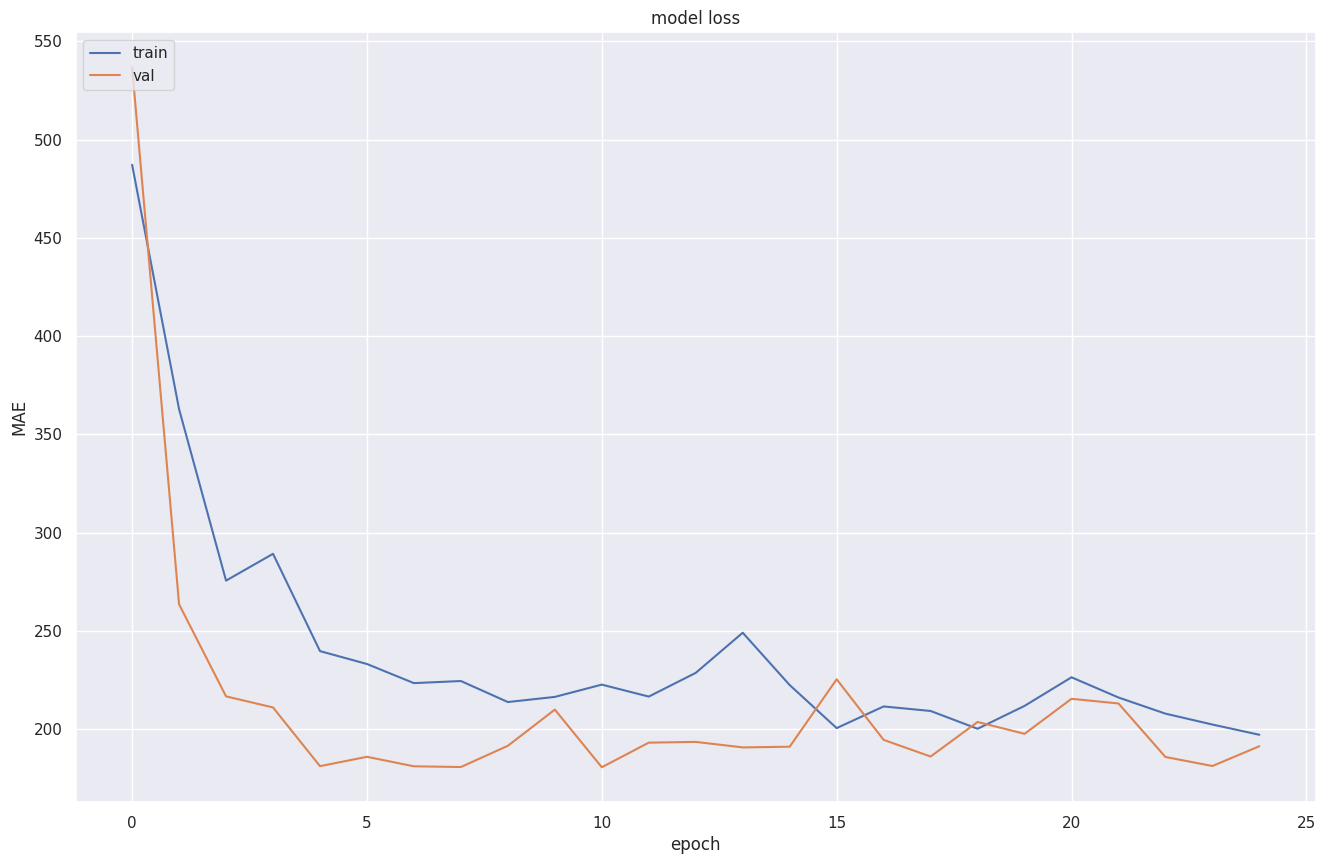

In [30]:
plt.plot(train_history.history['mae'])
plt.plot(train_history.history['val_mae'])
plt.title('model loss')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test

9/9 [==============================] - 7s 586ms/step
Test MAE Errror:  [212.81613159179688, 212.81613159179688]


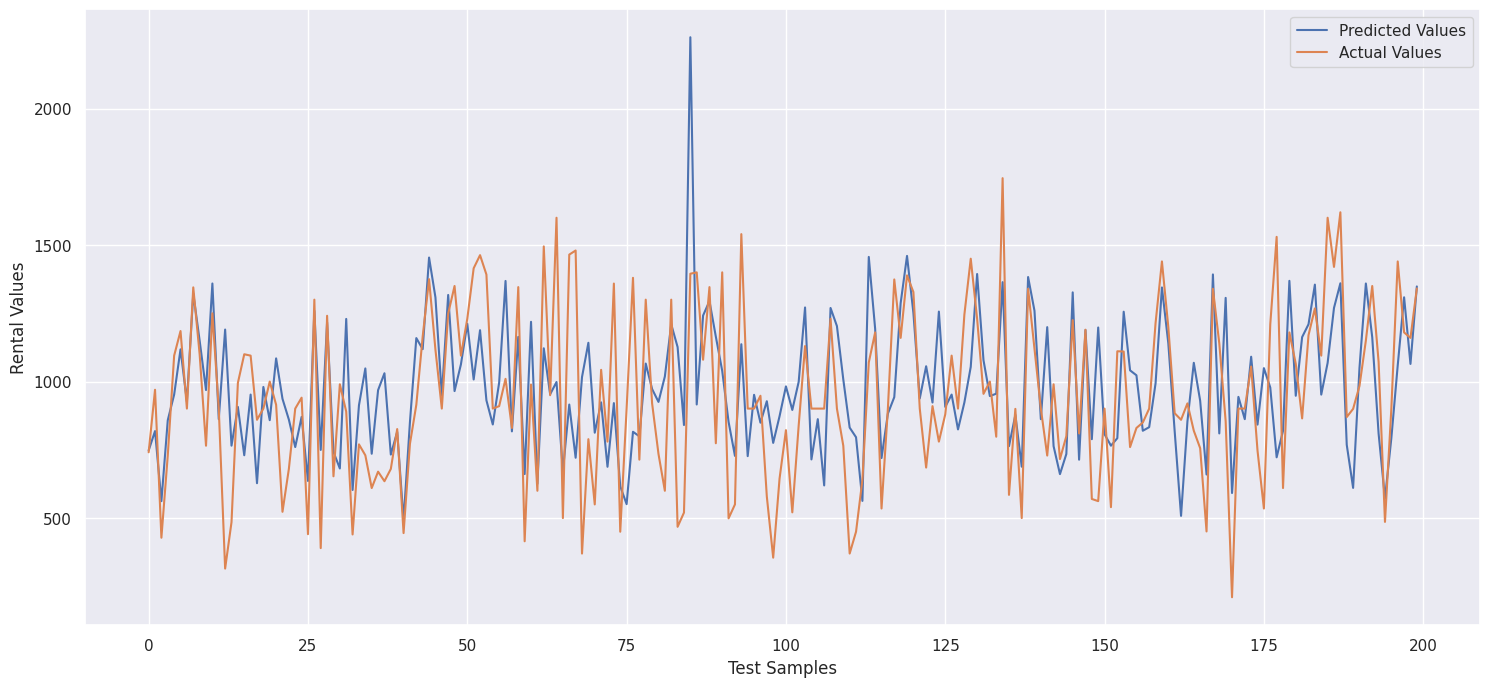

In [31]:
test_loss = []
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,8)


with tf.device('/device:GPU:0'):

    checkpoint_filepath = 'Bert_results/CheckPoints/bert_checkpoint'
    saved_model = tf.keras.models.load_model(  checkpoint_filepath, custom_objects=None, compile=True, options=None)

    predicted = model.predict([bert_test_input, test_df_others])

    loss_test = model.evaluate([bert_test_input[0],bert_test_input[1],bert_test_input[2], test_df_others]
                                      , bert_test_output, verbose=0)

    print("Test MAE Errror: ",loss_test )

    test_loss.append(loss_test)

    plt.plot(predicted[0:200], label = "Predicted Values")
    plt.plot(bert_test_output[0:200], label = "Actual Values")
    plt.xlabel('Test Samples')
    plt.ylabel('Rental Values')
    plt.legend()
    plt.show()

In [32]:
def relative_root_meansquared_error(y, pred) :
    num = np.sum(np.square(y - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss


y_pred= predicted
y_test= bert_test_output

print('MAE', mean_absolute_error(y_test, y_pred))
print( 'R2', r2_score(y_test, y_pred))
print('RMSE', sqrt(mean_squared_error(y_test, y_pred)))
print('RRMSE', relative_root_meansquared_error(y_test, y_pred))

MAE 212.81612584040715
R2 0.259983048205949
RMSE 273.481238297307
RRMSE 0.27351599807747834


In [33]:
model.save('BERT_Combined.keras')

✈

In [35]:
#model_load = tf.keras.models.load_model('BERT_Combined.keras')